In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import pandas as pd
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv(
    'Meetreeks_HVH.txt',
    delim_whitespace=True,
    header=None,
    names=['Date', 'Time', 'Elevation'])

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)

# Reorganize the DataFrame to have 'Datetime' as the first column
df = df[["Datetime", "Elevation"]]

df.head()

C:\Users\lucne\AppData\Local\Temp\ipykernel_16248\1021165046.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,Datetime,Elevation
0,1887-08-01 00:40:00,82
1,1887-08-01 13:10:00,72
2,1887-08-02 01:30:00,72
3,1887-08-02 14:20:00,72
4,1887-08-03 02:25:00,91


In [3]:
# Ensure Datetime is set as the index
df.set_index('Datetime', inplace=True)

# Add a 'Year' column for grouping
df['Year'] = df.index.year

# Calculate yearly averages
yearly_averages = df.groupby('Year')['Elevation'].mean()

# Map the yearly average back to the original DataFrame
df['Yearly_Avg'] = df['Year'].map(yearly_averages)

# Subtract the yearly average to obtain a stationary series
df['Elevation_Stationary'] = df['Elevation'] - df['Yearly_Avg']

# Drop the Year column if no longer needed
# df.drop(columns=['Year', 'Yearly_Avg'], inplace=True)

# Reset index if desired
df.reset_index(inplace=True)

print(df)


                 Datetime  Elevation  Year  Yearly_Avg  Elevation_Stationary
0     1887-08-01 00:40:00         82  1887   90.912162             -8.912162
1     1887-08-01 13:10:00         72  1887   90.912162            -18.912162
2     1887-08-02 01:30:00         72  1887   90.912162            -18.912162
3     1887-08-02 14:20:00         72  1887   90.912162            -18.912162
4     1887-08-03 02:25:00         91  1887   90.912162              0.087838
...                   ...        ...   ...         ...                   ...
94157 2020-12-29 14:15:00        130  2020  123.506365              6.493635
94158 2020-12-30 02:37:00        136  2020  123.506365             12.493635
94159 2020-12-30 14:46:00        148  2020  123.506365             24.493635
94160 2020-12-31 03:14:00        136  2020  123.506365             12.493635
94161 2020-12-31 15:27:00        144  2020  123.506365             20.493635

[94162 rows x 5 columns]


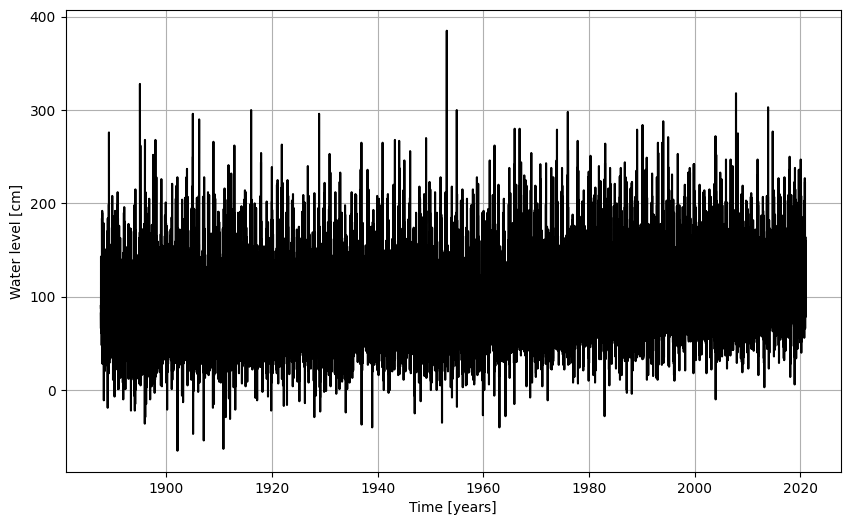

In [4]:
plt.figure(figsize=(10,6))
plt.plot(df["Datetime"], df["Elevation"], color = 'black')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
# plt.title('Water maxima for the period 1887-2020')
plt.grid()
plt.savefig('figures/timeseries.png')

5.312356215618939e-17


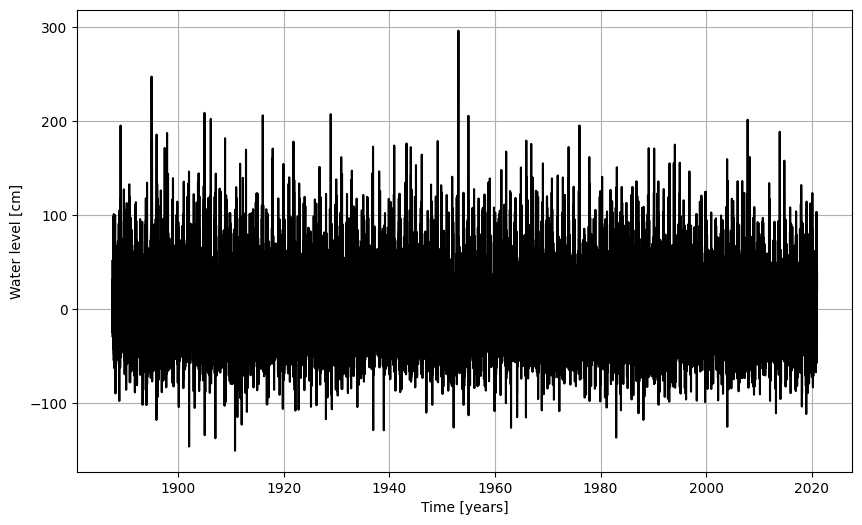

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df["Datetime"], df["Elevation_Stationary"], color = 'black')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
# plt.title('Water maxima for the period 1887-2020')
plt.grid()
plt.savefig('figures/timeseries.png')

print(df["Elevation_Stationary"].mean())

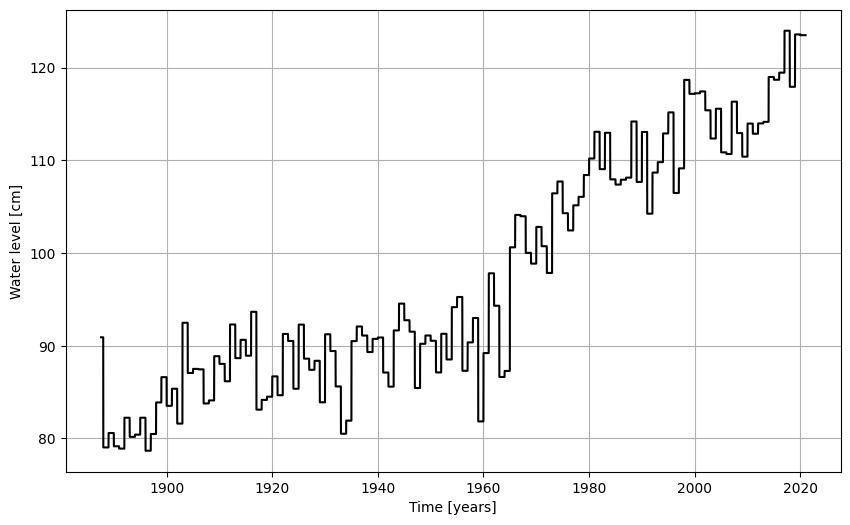

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df["Datetime"], df["Yearly_Avg"], color = 'black')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
# plt.title('Water maxima for the period 1887-2020')
plt.grid()
plt.savefig('figures/timeseries.png')

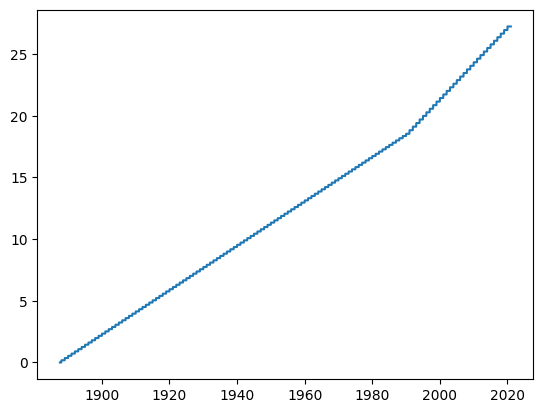

In [7]:
sea_level_correction = np.zeros(len(df["Elevation"]))
for i in range(len(sea_level_correction) - 1):
    if df["Datetime"][i+1].year != df["Datetime"][i].year:
        if df["Datetime"][i].year < 1990:
            sea_level_correction[i+1] = sea_level_correction[i] + 0.18
        else:
            sea_level_correction[i+1] = sea_level_correction[i] + 0.29
    else:
        sea_level_correction[i+1] = sea_level_correction[i]

plt.plot(df["Datetime"], sea_level_correction)

The shape of the sampled extremes is: (134, 5)


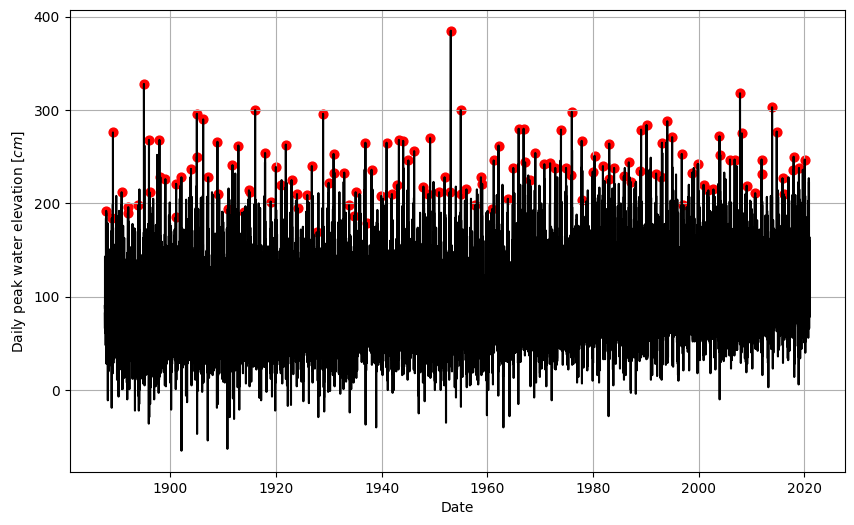

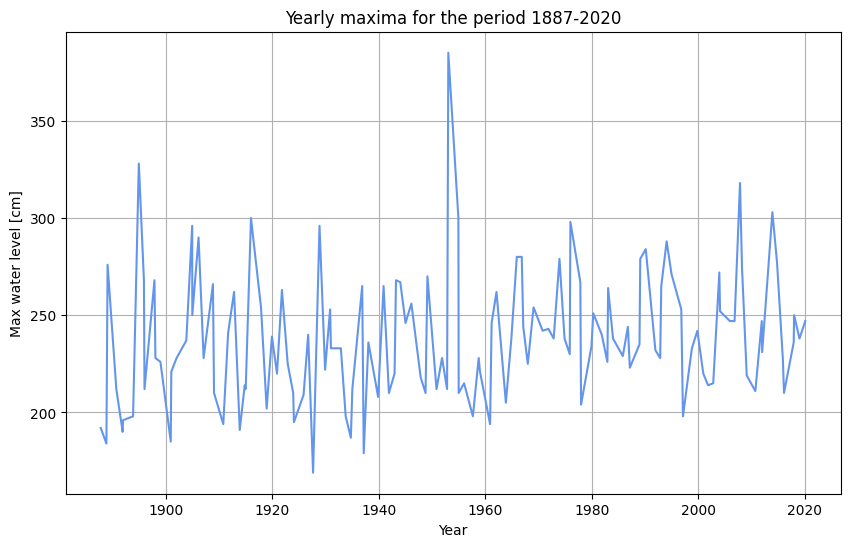

In [8]:
## Report yearly maxima for each year
idx_max = df.groupby(pd.DatetimeIndex(df['Datetime']).year)['Elevation'].idxmax()
YM = df.loc[idx_max]
print('The shape of the sampled extremes is:', YM.shape)

# Plot the yearly maxima on top of the time series
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation'],'k')
plt.scatter(YM['Datetime'], YM['Elevation'], 40, 'r')
plt.xlabel('Date')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.grid()
plt.savefig('figures/YM_timeseries.png')

## Plot the yearly maxima
plt.figure(figsize=(10,6))
plt.plot(YM['Datetime'], YM['Elevation'], color = 'cornflowerblue')
plt.xlabel('Year')
plt.ylabel('Max water level [cm]')
plt.title('Yearly maxima for the period 1887-2020')
plt.grid()

**Additional explanation for the graph above:**
In the graph plotted above, the yearly maxima of waterlevels at Hoek van Holland are plotted. It can be observed that the maximum generally lie between 200-300 cm. At one instance, a very high peak was observed with a value of almost 400 cm. This point in time corresponds to the flood disaster of 1953, which flooded large parts of Zeeland and Zuid-Holland. 

Threshold defined: 200 m.
Declustering time is: 96 hours.
The shape of the sampled extremes is: (207,)


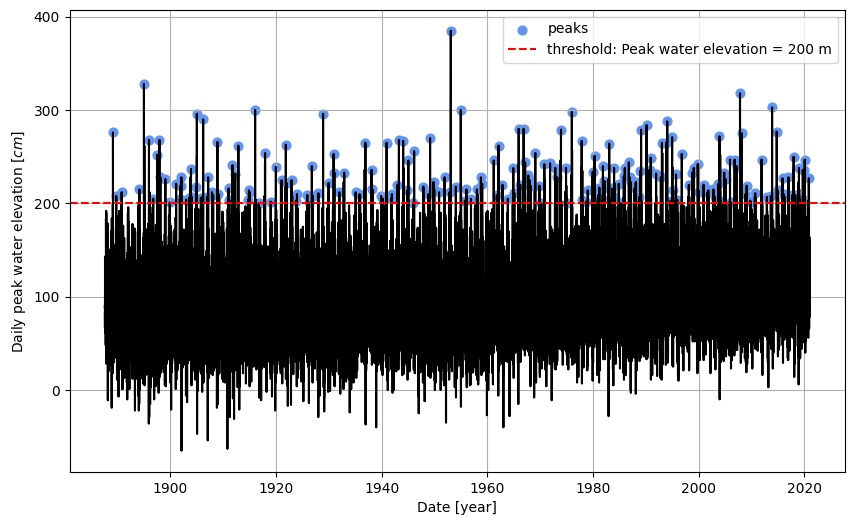

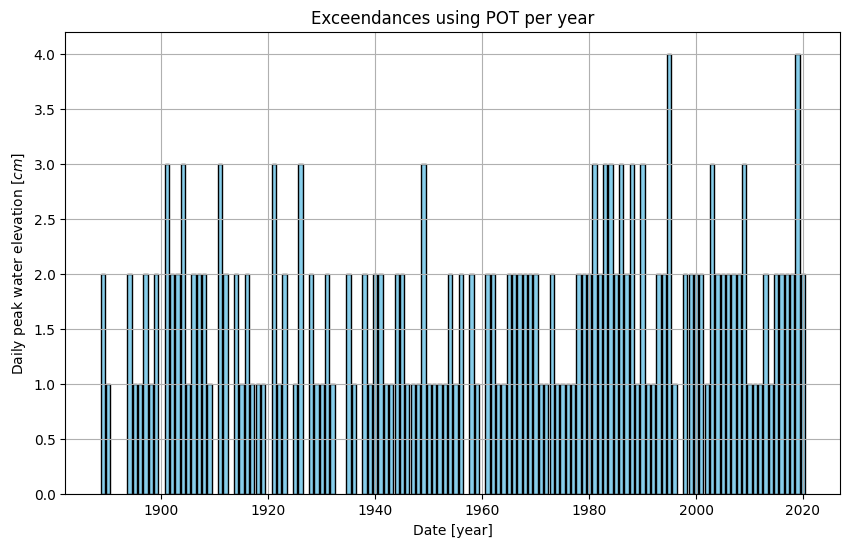

In [9]:
## Define the threshold
threshold = 200

print(f'Threshold defined: {threshold} m.')
distance = 24 * 4
print(f'Declustering time is: {distance} hours.')
peaks, _ = find_peaks(df['Elevation'], height=threshold, distance=distance)
print('The shape of the sampled extremes is:', peaks.shape)

peak_times = df['Datetime'].iloc[peaks]
exceedances_per_year = peak_times.groupby(peak_times.dt.year).size()

# Plot exceedances on the time series of all observations
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation'],'k')
plt.scatter(df.iloc[peaks, 0], df.iloc[peaks, 1], 40, color='cornflowerblue', label='peaks')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'threshold: Peak water elevation = {threshold} m')
plt.xlabel('Date [year]')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.legend()
# plt.title(f'Peaks selected by POT for dataset with a declustering time of {distance} hours') # title already in Google docs
plt.grid()
plt.savefig('figures/POT_timeseries.png')

plt.figure(figsize=(10,6))
plt.bar(exceedances_per_year.index, exceedances_per_year.values, color='skyblue', edgecolor='black')
plt.title('Exceendances using POT per year')
plt.xlabel('Date [year]')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.grid()
plt.savefig('figures/POT_yearly_exc.png')

Threshold defined: 100 m.
Declustering time is: 96 hours.
The shape of the sampled extremes is: (208,)


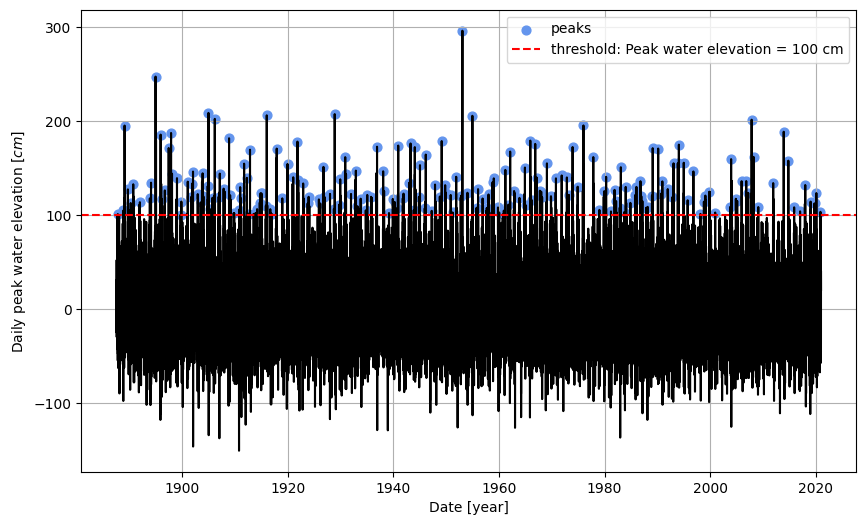

In [14]:
## Define the threshold
threshold = 100

print(f'Threshold defined: {threshold} m.')
distance = 24 * 4
print(f'Declustering time is: {distance} hours.')
peaks, _ = find_peaks((df['Elevation_Stationary']), height=threshold, distance=distance)
print('The shape of the sampled extremes is:', peaks.shape)

peak_times = df['Datetime'].iloc[peaks]

# Plot exceedances on the time series of all observations
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation_Stationary'],'k')
plt.scatter(df.iloc[peaks, 0], df.iloc[peaks, 4], 40, color='cornflowerblue', label='peaks')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'threshold: Peak water elevation = {threshold} cm')
plt.xlabel('Date [year]')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.legend()
# plt.title(f'Peaks selected by POT for dataset with a declustering time of {distance} hours') # title already in Google docs
plt.grid()
plt.savefig('figures/POT_timeseries.png')

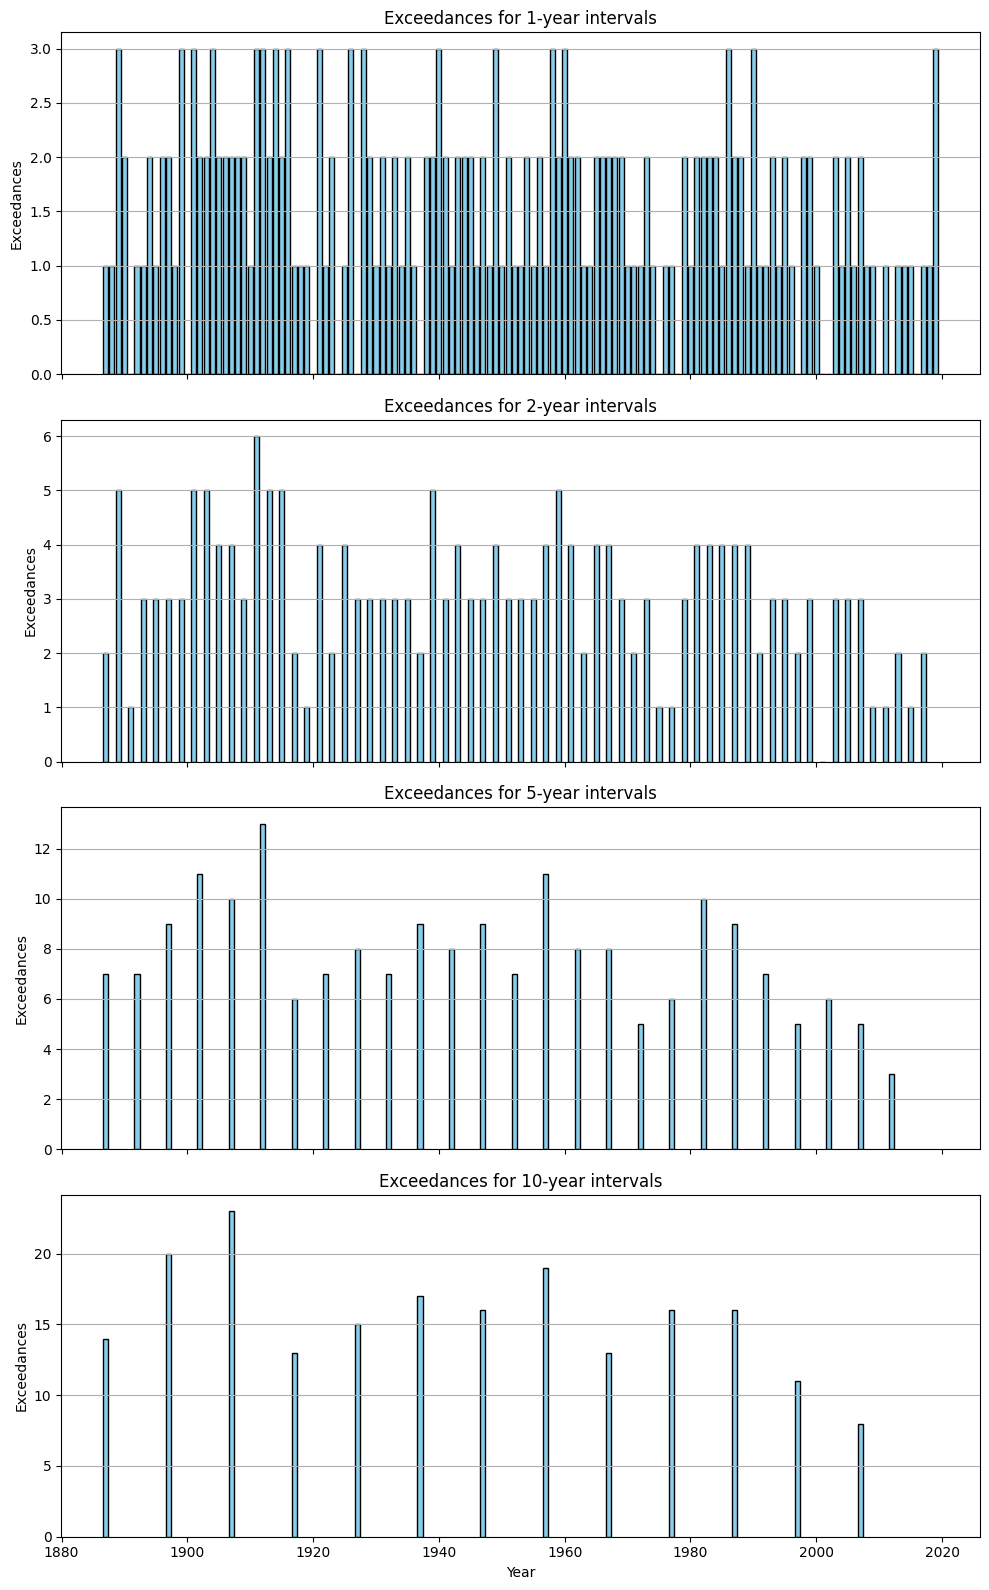

In [15]:
import matplotlib.pyplot as plt

# Define the intervals for grouping
intervals = [1, 2, 5, 10]  # years
results = {}

for interval in intervals:
    # Create bins based on the interval
    start_year = peak_times.dt.year.min()
    end_year = peak_times.dt.year.max()
    bins = range(start_year, end_year + 1, interval)
    
    # Group by bins
    peak_bins = pd.cut(peak_times.dt.year, bins=bins, right=False, labels=bins[:-1])
    exceedances = peak_bins.value_counts().sort_index()
    
    # Store the results for this interval
    results[f"{interval}-year"] = exceedances

# Plot the results
fig, axes = plt.subplots(len(intervals), 1, figsize=(10, len(intervals) * 4), sharex=True)

for i, (key, value) in enumerate(results.items()):
    axes[i].bar(value.index.astype(int), value.values, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Exceedances for {key} intervals")
    axes[i].set_ylabel("Exceedances")
    axes[i].grid(axis='y')

# Common X-axis label
axes[-1].set_xlabel("Year")

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Define the time difference threshold (e.g., two weeks = 14 days)
time_threshold = pd.Timedelta(days=60)

# Reset indices to ensure alignment
peak_times = peak_times.reset_index(drop=True)
time_differences = peak_times.diff()

# Find instances where the time difference is less than the threshold
close_extremes = time_differences[time_differences <= time_threshold]

# Get the indices of the peaks that are close to each other
close_extreme_indices = close_extremes.index

# Print the results
print(f"Number of close extremes: {len(close_extreme_indices)}")
print("Close extremes occurred at the following times:")
for idx in close_extreme_indices:
    print(f"- {peak_times[idx - 1]} and {peak_times[idx]} (Difference: {time_differences[idx]})")

# Optional: Filter the peaks DataFrame for closer inspection
close_extreme_pairs = pd.DataFrame({
    "First Peak": peak_times[close_extreme_indices - 1].values,
    "Second Peak": peak_times[close_extreme_indices].values,
    "Time Difference": time_differences[close_extreme_indices].values
})

# Display the DataFrame
print(close_extreme_pairs)

Number of close extremes: 18
Close extremes occurred at the following times:
- 1901-10-09 13:20:00 and 1901-11-28 17:05:00 (Difference: 50 days 03:45:00)
- 1901-11-28 17:05:00 and 1902-01-26 16:40:00 (Difference: 58 days 23:35:00)
- 1903-11-22 04:55:00 and 1904-01-16 14:40:00 (Difference: 55 days 09:45:00)
- 1904-11-08 14:55:00 and 1904-12-30 21:30:00 (Difference: 52 days 06:35:00)
- 1911-01-02 04:35:00 and 1911-02-26 13:40:00 (Difference: 55 days 09:05:00)
- 1914-09-18 13:55:00 and 1914-11-11 23:05:00 (Difference: 54 days 09:10:00)
- 1921-11-06 19:05:00 and 1921-12-31 16:25:00 (Difference: 54 days 21:20:00)
- 1930-11-23 05:10:00 and 1931-01-17 14:10:00 (Difference: 55 days 09:00:00)
- 1941-10-19 01:15:00 and 1941-12-07 17:05:00 (Difference: 49 days 15:50:00)
- 1949-10-26 18:50:00 and 1949-12-18 01:05:00 (Difference: 52 days 06:15:00)
- 1974-11-28 13:19:00 and 1975-01-26 01:10:00 (Difference: 58 days 11:51:00)
- 1977-11-15 04:44:00 and 1978-01-03 20:06:00 (Difference: 49 days 15:22:00)

**Additional explanation for the graph above:**
In the upper graph, Peak Over Threshold is used to obtain extreme values for the water levels at Hoek van Holland. In this plot it can already be observed that the frequency of the exceedences increases after 1970. This is also visible in the lower graph, where the number of exceedences per year is plotted. In the last plot, the peaks are plotted over the total time series.

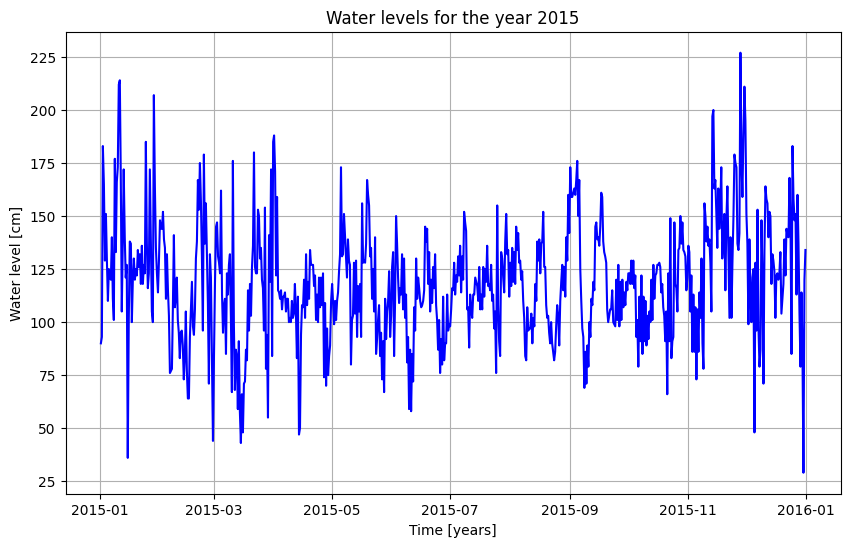

In [13]:
## Plot values for the year 2015
df_2015 = df[df['Datetime'].dt.year == 2015]
plt.figure(figsize=(10,6))
plt.plot(df_2015['Datetime'], df_2015['Elevation'], color = 'blue')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('Water levels for the year 2015')
plt.grid()